<center>

# Discrete Event Systems

## Home Assignment 2

### Nonblocking and Controllable Supervisor Synthesis

- - -

# Introduction

The objective of this home assignment is to extend the results already obtained in Home Assignment 1 by including uncontrollable events and generating a supervisor that is both nonblocking and controllable. This will be achieved by implementing two algorithms already presented in the lecture notes in Python, but also implementing a new function that generates uncontrollable states.

This home assignment is performend in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on PingPong**

## Comments and Recommendations
Once again:

* This assignment is written for Python 3.5 or later! Executing it with Python version 2.7 won't work.
* If you get stuck with Python or Jupyter, try to google it! E.g. your search query could be *"python --INSERT ERROR HERE--"*. Chances are high, heaps of people had the same problem before you.
* To show line numbers in a cell, go to *View* and click on *Toggle Line Numbers*.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! We will test your code with additional edge cases. So convice yourself that everything is correct before you submit.

- - -

# Preliminaries

In this assignment, we will re-use parts of Assignment 1. Make sure to execute the cell below.

In [1]:
from util import Automaton, Transition
from util import plot_automaton
from util import filter_trans_by_source, filter_trans_by_events, filter_trans_by_target
from util import extract_elems_from_trans, flip_trans 
from util import merge_label, cross_product 

def reach(events, trans, start_states, forbidden):
    """
    Returns the forward reachable states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    reach_states = start_states - forbidden
    last_reach_states = set()
    while not reach_states == last_reach_states:
        last_reach_states = reach_states.copy()
        t = filter_trans_by_source(trans, reach_states)
        t = filter_trans_by_events(t, events)
        reach_states |= (extract_elems_from_trans(t, 'target') - forbidden)
    return reach_states


def coreach(events, trans, start_states, forbidden):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    return reach(events, flip_trans(trans), start_states, forbidden)


def synch(aut1, aut2):
    """
    Returns the synchronous composition of two automata.
    
    :param aut1: Automaton
    :param aut2: Automaton
    """
    states = cross_product(aut1.states, aut2.states)
    init = merge_label(aut1.init, aut2.init)
    events = aut1.events | aut2.events
    
    # Add self loops
    trans1 = aut1.trans.copy()
    for event in aut2.events - aut1.events:
        for state in aut1.states:
            trans1.add(Transition(state, event, state))
    
    trans2 = aut2.trans.copy()
    for event in aut1.events - aut2.events:
        for state in aut2.states:
            trans2.add(Transition(state, event, state))
    
    # Transitions
    trans = set()
    for t1 in trans1:
        for t2 in trans2:
            if t1.event == t2.event:
                trans.add(Transition(merge_label(t1.source, t2.source),
                                     t1.event,
                                     merge_label(t1.target, t2.target)))
    
    # Marked states
    m1 = aut1.marked if aut1.marked else aut1.states
    m2 = aut2.marked if aut2.marked else aut2.states
    marked = cross_product(m1,m2)
    
    # Forbidden states
    forbidden = cross_product(aut1.forbidden, aut2.states) | cross_product(aut1.states, aut2.forbidden)
    
    # Removing unreachable states
    reachable = reach(events, trans, {init}, set())
    marked &= reachable
    forbidden &= reachable
    trans = filter_trans_by_source(trans, reachable)
    
    # Create synchronized automaton
    return Automaton(reachable, init, events, trans, marked, forbidden)

- - -

# Task 1

## Synthesis

Using `reach`, `coreach` and `synch` from the first assignment, your task is now to implement:

$\qquad$ `S = supervisor(P, Sp, sigma_u)`
    
that, given a plant $P$, a specification $Sp$ and a set of uncontrollable events $\Sigma_u$, generates a nonblocking and controllable supervisor $S$. Note that $\Sigma_u \subseteq \Sigma^P$, and it is assumed that $\Sigma^{Sp} \subseteq \Sigma^P$, where $\Sigma^P$ and $\Sigma^{Sp}$ are the event sets of the plant $P$ and the specification $Sp$. The supervisor is generated by implementing and applying algorithm 3 in the lecture notes.

Your code should raise a `ValueError` when there exist no supervisor that can fulfill the specification:

$\qquad$ `if noSupervisorExists: raise ValueError`

* *Note:* If more than one plant and/or specification model are involved, the total plant and/or specification model is generated by synchronizingthe local models. For instance, $P_1, P_2, Sp_1$ and $Sp_2$ gives $P = P_1 \parallel P_2$ and $Sp = Sp_1 \parallel Sp_2$.

* *Note:* One of the input sets in Algorithm 3 is the set of forbidden states. Implement specifically a function that generates this forbidden state set, including both explicitly forbidden states and uncontrollable states.

* *Note:* In the synchronization of two automaton $A$ and $B$, the names of the original states $q^A$ and $q^B$ can be identified, since the merge state function generates state names $q^A.q^B$. Identification of the reachable states in $P \parallel Sp$ and the corresponding states in $P$ and $Sp$ simplifies the generation of the uncontrollable states. 

Here are some helper functions that might help you with your implementation of the algorithm in code.

In [2]:
# These two functions follow the definition of uncontrollable states given on page 100 in the Lecture Notes
def is_defined_for_p(p_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in P
    with the merged_source as start state.
    
    :param p_trans: Set of transitions in automaton P
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Set of uncontrollable events shared between P and Q.
    """
    validate_inputs(p_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(p_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.startswith(str(t.source))}
    return u_trans_from_merged_source != set()

def is_defined_for_q(q_trans, merged_source, shared_sigma_u):
    """
    Boolean check whether there is an uncontrollable transition defined in Q
    with the merged_source as start state.
    
    :param q_trans: Set of transitions in automaton Q
    :param merged_source: String label of the merged state in P||Q
    :param shared_sigma_u: Set of uncontrollable events shared between P and Q.
    """
    validate_inputs(q_trans, merged_source, shared_sigma_u)
    uncontrollable_trans = filter_trans_by_events(q_trans, shared_sigma_u)
    u_trans_from_merged_source = {t for t in uncontrollable_trans 
                                  if merged_source.endswith(str(t.source))}
    return u_trans_from_merged_source != set()

def validate_inputs(trans, source, events):
    assert type(trans) is set
    assert type(source) is str
    assert type(events) is set

In [3]:
# Now implement the function in code
def supervisor(P, Sp, sigma_u):
    """
    Generates a nonblocking and controllable supervisor for the synchronized system P||Sp.
    
    :param P: automaton of the palnt
    :param Sp: automaton of the specification
    :param sigma_u: set of uncontrollable events
    """
    S0 = synch(P,Sp)
    
    # Quc = {<p, q> ∈ Q^{P||Sp} | ∃σ_u ∈ Σ_u ∩ Σ^Sp AND δ^P (p, σ_u) ∈ Q^P AND δ^Sp(q, σ_u) not defined}
    Xk = S0.forbidden | {q for q in S0.states if is_defined_for_p(P.trans,q, sigma_u&Sp.events) and not  
                                                 is_defined_for_q(Sp.trans,q, sigma_u&Sp.events)} 
    print('Initial Uncontrollable: {}\n'.format(Xk))
    
    while True:
        X = Xk
        Qp  = coreach(S0.events, S0.trans, S0.marked, X)
        print('New Blocking: {}'.format(S0.states-Qp-X))
        Qpp = coreach(sigma_u, S0.trans, S0.states-Qp, set())
        print('New Uncontrollable: {}\n'.format(Qpp - (S0.states-Qp) ))
        Xk = X | Qpp
        if X == Xk: break
    
    safeStates = S0.states-Xk #reach(S0.events, S0.trans, S0.states-Xk, S0.forbidden)    
    print('SafeStates: {}\n'.format(safeStates))
    
    marked = S0.marked & safeStates
    forbidden = S0.forbidden & safeStates
    trans = {t for t in S0.trans if set([t.source,t.target]).issubset(safeStates)}
    events = S0.events
    
    if not safeStates or not {S0.init}.issubset(safeStates): raise ValueError('There exist no supervisor that can fulfill the specification')
    return Automaton(states=safeStates, init=S0.init, events=events, trans=trans, marked=marked, forbidden=forbidden)

In [4]:
# Test case 0 - Single states
P = Automaton(states={1},
              init=1,
              events=set(),
              trans=set())
Sp = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
S = supervisor(P, Sp, set())
assert S.states == {'1.2'}, 'TC 0.1 - got {} instead'.format(S.states)
assert S.events == set(), 'TC 0.2 - got {} instead'.format(S.events)



# Test case 1 - Three states
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, set())
assert S.states == {'1.1', '2.2', '3.2'}, 'TC 1.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 1.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 1.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 1.4 - got {} instead'.format(S.forbidden)



# Test case 2 - Three states and an uncontrolable event
P = Automaton(states={1, 2, 3},
              init=1,
              events={'a', 'b'},
              trans={Transition(1, 'a', 2), Transition(2, 'b', 3)})
Sp = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)})
S = supervisor(P, Sp, {'b'})
assert S.states == {'1.1'}, 'TC 2.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 2.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 2.3 - got {} instead'.format(S.events)
assert S.forbidden == set(), 'TC 2.4 - got {} instead'.format(S.forbidden)

# Test case 3 - Two uncontrollable transitions in a sequence
P = Automaton(states={1},
              init=1,
              events=set(),
              trans=set())
Sp1 = Automaton(states={1, 2, 3, 4},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2),Transition(2, 'b', 3),Transition(3, 'b', 4)},
               marked={1,2})
Sp2 = Automaton(states={1, 2, 3, 4},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2),Transition(2, 'b', 3),Transition(3, 'b', 4)},
               marked={1,2})
S = supervisor(P, Sp1, {'b'})
assert S == supervisor(P, Sp2, {'b'})
assert S.states == {'1.1'}, 'TC 3.1 - got {} instead'.format(S.states)
assert S.init == '1.1', 'TC 3.2 - got {} instead'.format(S.init)
assert S.events == {'a', 'b'}, 'TC 3.3 - got {} instead'.format(S.events)
assert S.trans == set(), 'TC 3.4 - got {} instead'.format(S.forbidden)
assert S.forbidden == set(), 'TC 3.4 - got {} instead'.format(S.forbidden)

Initial Uncontrollable: set()

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'1.2'}

Initial Uncontrollable: set()

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'3.2', '2.2', '1.1'}

Initial Uncontrollable: {'2.2'}

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'1.1'}

Initial Uncontrollable: set()

New Blocking: {'1.3', '1.4'}
New Uncontrollable: {'1.2'}

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'1.1'}

Initial Uncontrollable: set()

New Blocking: {'1.3', '1.4'}
New Uncontrollable: {'1.2'}

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'1.1'}



---

# Task 2

Evaluate the implementation in Task 1 by generating a nonblocking and controllable supervisor $S$ for the plant and specification models given in 

* Example 7.5 in the Lecture Notes

* Example 7.6 in the Lecture Notes

* Task 3 in the Exam Oct 24, 2015

## Example 7.5

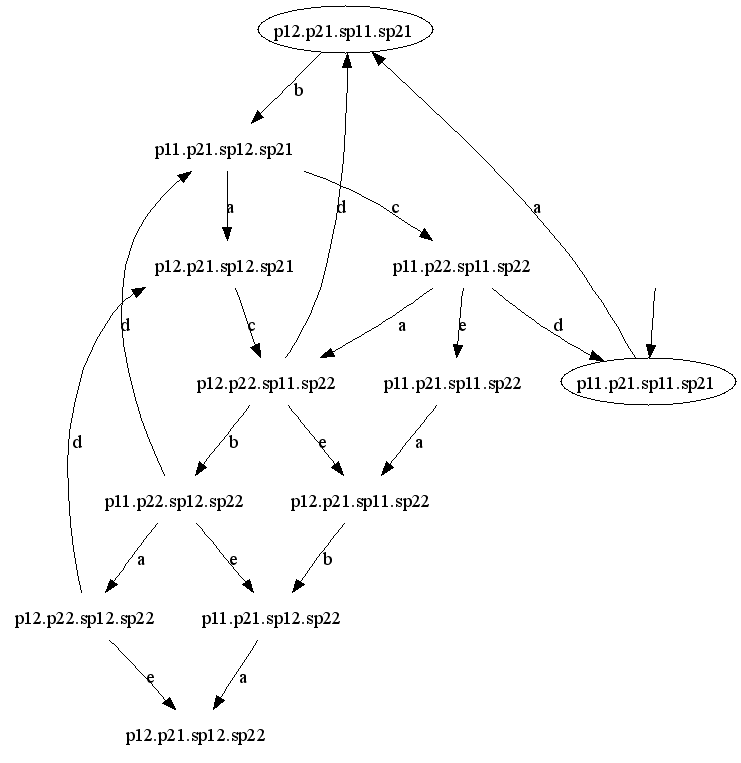

Initial Uncontrollable: {'p12.p21.sp12.sp22', 'p12.p21.sp12.sp21', 'p12.p22.sp12.sp22'}

New Blocking: {'p11.p21.sp11.sp22', 'p12.p21.sp11.sp22', 'p11.p21.sp12.sp22'}
New Uncontrollable: set()

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'p11.p22.sp12.sp22', 'p12.p21.sp11.sp21', 'p11.p21.sp11.sp21', 'p11.p22.sp11.sp22', 'p11.p21.sp12.sp21', 'p12.p22.sp11.sp22'}



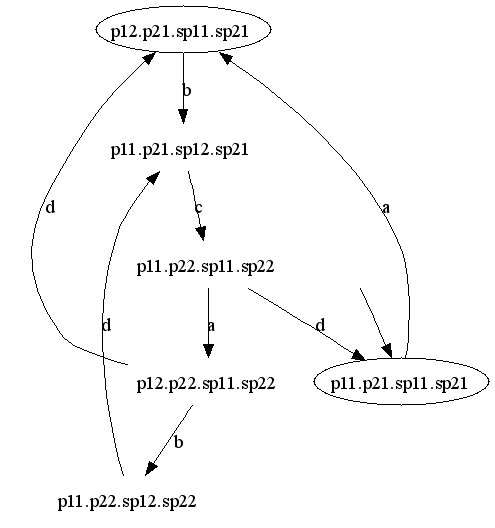

In [5]:


# Create automata P1, P2, SP1 and SP2
P1 = Automaton(states={'p11','p12'},
              init='p11',
              events={'a','b'},
              trans={Transition('p11', 'a', 'p12'),Transition('p12', 'b', 'p11')})
P2 = Automaton(states={'p21','p22'},
              init='p21',
              events={'c','d','e'},
              trans={Transition('p21', 'c', 'p22'),Transition('p22', 'd', 'p21'),Transition('p22', 'e', 'p21')})
SP1 = Automaton(states={'sp11','sp12'},
               init='sp11',
               events={'b','c'},
               trans={Transition('sp11', 'b', 'sp12'),Transition('sp12', 'c', 'sp11')},
               marked={'sp11'})
SP2 = Automaton(states={'sp21','sp22'},
               init='sp21',
               events={'c','d'},
               trans={Transition('sp21', 'c', 'sp22'),Transition('sp22', 'd', 'sp21')},
               marked={'sp21'})

Sp = synch(SP1, SP2)
P = synch(P1, P2)
display(plot_automaton(synch(P,Sp), 'S_7dot5'))
S = supervisor(P, Sp, {'b'})
display(plot_automaton(S, 'S_7dot5'))

In [6]:
assert type(S) is Automaton

# This is optional but simplifies the testing
p1_states={'p11','p12'}
p2_states={'p21','p22'}
sp1_states={'sp11','sp12'}
sp2_states={'sp21','sp22'}
events={'a', 'b', 'c', 'd', 'e'}
assert all({s[0:3] in p1_states and s[4:7] in p2_states and s[8:12] in sp1_states and s[13:17] in sp2_states 
            for s in S.states}), 'This is optional but, to simplify the tests, \
            please use only the state name from the example and synchronize in the same order, \
            i.e init state whould be p1.p2.sp1.sp2'
assert all({e in events for e in S.events}), 'This is optional but, to simplify the tests, \
            please use only the event labels from the example.'

## Example 7.6

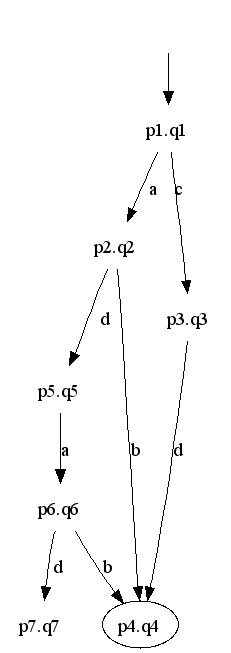

Initial Uncontrollable: {'p7.q7'}

New Blocking: set()
New Uncontrollable: {'p6.q6'}

New Blocking: {'p5.q5'}
New Uncontrollable: {'p2.q2'}

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'p1.q1', 'p4.q4', 'p3.q3'}



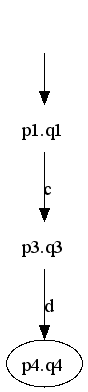

In [7]:
P = Automaton(states={'p1','p2','p3','p4','p5','p6','p7','p8'},
              init='p1',
              events={'a','b','c','d'},
              trans={Transition('p1', 'a', 'p2'),
                     Transition('p2', 'd', 'p5'),
                     Transition('p5', 'a', 'p6'),
                     Transition('p6', 'd', 'p7'),
                     Transition('p7', 'd', 'p8'),
                     Transition('p1', 'c', 'p3'),
                     Transition('p2', 'b', 'p4'),
                     Transition('p3', 'd', 'p4'),
                     Transition('p6', 'b', 'p4')},
              marked={'p4'})
Sp = Automaton(states={'q1','q2','q3','q4','q5','q6','q7'},
              init='q1',
              events={'a','b','c','d'},
              trans={Transition('q1', 'a', 'q2'),
                     Transition('q2', 'd', 'q5'),
                     Transition('q5', 'a', 'q6'),
                     Transition('q6', 'd', 'q7'),
                     Transition('q1', 'c', 'q3'),
                     Transition('q2', 'b', 'q4'),
                     Transition('q3', 'd', 'q4'),
                     Transition('q6', 'b', 'q4')},
               marked={'q4'})

display(plot_automaton(synch(P,Sp), 'S_7dot6'))
S = supervisor(P, Sp, {'d'})
plot_automaton(S, 'S_7dot6')

In [8]:
assert type(S) is Automaton

# These tests are optional but simplify the hidden tests
p_states={'p1','p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8'}
q_states={'q1','q2', 'q3', 'q4', 'q5', 'q6', 'q7'}
events={'a', 'b', 'c', 'd'}
assert all({s.startswith(tuple(p_states)) and s.endswith(tuple(q_states)) for s in S.states}), '\
    This is optional but, to simplify the tests, please use only the state name from the example \
    and synchronize in the same order, i.e init state whould be p1.q1'
assert all({e in events for e in S.events}), '\
    This is optional but, to simplify the tests, please use only the event labels from the example.'

## Task 3 - Exam Oct 2015

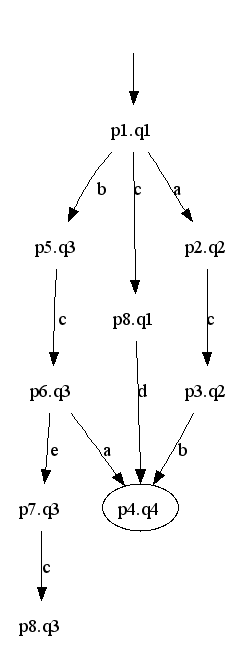

Initial Uncontrollable: {'p3.q2', 'p8.q3'}

New Blocking: {'p7.q3', 'p2.q2'}
New Uncontrollable: {'p6.q3'}

New Blocking: {'p5.q3'}
New Uncontrollable: set()

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'p8.q1', 'p1.q1', 'p4.q4'}



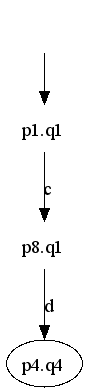

In [9]:
P = Automaton(states={'p1','p2','p3','p4','p5','p6','p7','p8'},
              init='p1',
              events={'a','b','c','d','e'},
              trans={Transition('p1', 'a', 'p2'),
                     Transition('p2', 'c', 'p3'),
                     Transition('p3', 'b', 'p4'),
                     Transition('p3', 'd', 'p4'),
                     Transition('p1', 'b', 'p5'),
                     Transition('p5', 'c', 'p6'),
                     Transition('p6', 'e', 'p7'),
                     Transition('p7', 'c', 'p8'),
                     Transition('p8', 'd', 'p4'),
                     Transition('p6', 'a', 'p4'),
                     Transition('p1', 'c', 'p8')},
              marked={'p4'})
Sp = Automaton(states={'q1','q2','q3','q4'},
              init='q1',
              events={'a','b','d'},
              trans={Transition('q1', 'a', 'q2'),
                     Transition('q2', 'b', 'q4'),
                     Transition('q1', 'd', 'q4'),
                     Transition('q1', 'b', 'q3'),
                     Transition('q3', 'a', 'q4')},
               marked={'q4'})

display(plot_automaton(synch(P,Sp), 'S_7dot6'))

S = supervisor(P, Sp, {'d', 'e'})
plot_automaton(S, 'S_3_15')

In [10]:
assert type(S) is Automaton

---

# Task 3

Two people named **A** and **B** are playing a simple game. A number of sticks are lain
out on the ground and the players take alternately one or two sticks. Note that at least
one stick must be picked. The player that ends up with the last stick has lost the game.
Player **A** is always the one that starts picking sticks. A related problem is introduced
in Task 6.3 in the DES-exercises.

* Model this game by an automaton `P`, with an initial number of five sticks. Hint: identify the events and the states.

* Create a specification `Sp` by introducing a marked state in `P`, specifying that player **A** is to win and player **B** is to loose. Remember that the player left with only the final stick to pick, is the loser.

* Generate by the algorithm in *Task 1* a supervisor `S` which guarantees that player **A** wins the game, i.e `S = supervisor(P, Sp, sigma_u)`. *Note* that the set of uncontrollable events `sigma_u` must first be decided.

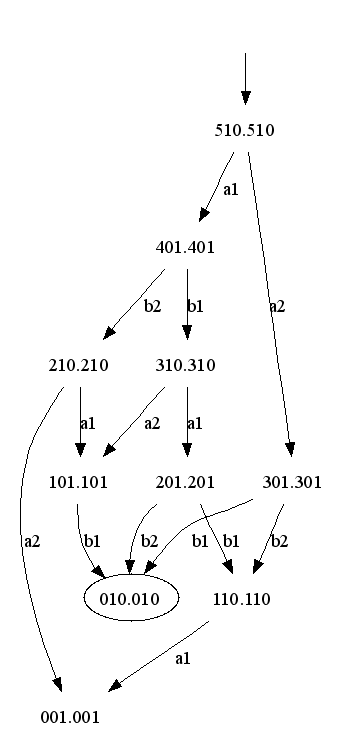

Initial Uncontrollable: set()

New Blocking: {'110.110', '001.001'}
New Uncontrollable: {'301.301', '201.201'}

New Blocking: set()
New Uncontrollable: set()

SafeStates: {'510.510', '310.310', '010.010', '401.401', '101.101', '210.210'}



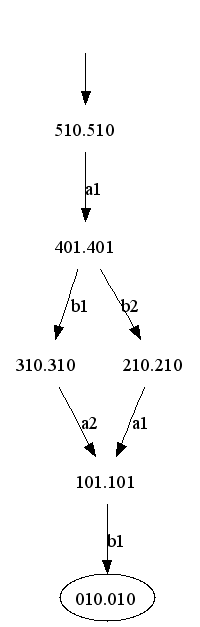

In [11]:
P = Automaton(states={'510','410','310','210','110','010',
                      '401','301','201','101','001'},
              init='510',
              events={'a2','a1','b2','b1'},
              trans={Transition('510', 'a2', '301'),
                     Transition('510', 'a1', '401'),
                     
                     Transition('201', 'b2', '010'),
                     Transition('201', 'b1', '110'),
                     Transition('301', 'b2', '110'),
                     Transition('301', 'b1', '010'),
                     Transition('401', 'b2', '210'),
                     Transition('401', 'b1', '310'),
                     
                     Transition('110', 'a1', '001'),
                     Transition('210', 'a2', '001'),
                     Transition('210', 'a1', '101'),
                     Transition('310', 'a2', '101'),
                     Transition('310', 'a1', '201'),
                     
                     Transition('101', 'b1', '010')})
import copy
Sp = copy.copy(P)
Sp.marked = {'010'}

display(plot_automaton(synch(P,Sp), 'S_3_15'))

sigma_u = {'b1','b2','b3'}
S = supervisor(P, Sp, sigma_u)
display(plot_automaton(S, 'S_3_15'))

In [12]:
assert type(P) is Automaton
assert type(Sp) is Automaton
assert type(S) is Automaton

assert P.states == Sp.states
assert P.events == Sp.events
assert P.init == Sp.init
assert P.trans == Sp.trans
assert P.marked == set() or P.marked == P.states
assert len(Sp.marked) == 1

- - -

Great! You have reached the bottom of the page. If you are done,

* Save the notebook
* Upload the .ipynb file to Ping Pong
* Go for fika! 